<a href="https://colab.research.google.com/github/Bovi-analytics/Hut-et-al-2021/blob/master/WalkingTime_MonthsInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for walking time MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following object is masked from ‘package:ggplot2’:

    vars


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: surviv

## Data loading into dataframe

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=WalkingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-39.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=WalkingTimeMinutesPer2Hours/part-00000-tid-5876581890551720600-0e9afc0a-339b-4a8d-9159-2f92fdf60451-17582-38.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=WalkingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-39.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, -1, 10)) %>%
   dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    LactationNumber = factor(TransitionLactationNumber),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    numMonthsInMilk = TransitionMonthsInMilk,
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, numMonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType, LactationNumber) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 × 10
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk numMonthsInMilk
  <fct>            <fct>          <fct>  <fct>                  <int>
1 70               2297           1      3                          3
2 7829             2011           3+     7                          7
3 7831             2011           3+     5                          5
4 72               2297           2      3                          3
5 71               2297           1      6                          6
6 7955             2011           3+     5                          5
# … with 5 more variables: CalvingSeason <fct>, Hour <fct>, SensorValue <dbl>,
#   MilkingType <fct>, LactationNumber <fct>


In [ ]:
%%R
str(AnalysisData)

tibble [54,073 × 10] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1051 levels "1","2","3","4",..: 70 671 672 72 71 678 708 679 736 76 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 1 1 2 2 1 1 1 1 2 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 1 3 3 2 1 3 3 3 3 2 ...
 $ MonthsInMilk    : Factor w/ 12 levels "-1","0","1","2",..: 5 9 7 5 8 7 8 6 5 4 ...
 $ numMonthsInMilk : int [1:54073] 3 7 5 3 6 5 6 4 3 2 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 3 1 4 2 4 2 1 3 4 ...
 $ Hour            : Factor w/ 2 levels "22","23": 1 2 1 2 1 1 1 2 1 1 ...
 $ SensorValue     : num [1:54073] 55.3 29 48.4 53.7 61.3 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 2 2 2 2 2 2 ...
 $ LactationNumber : Factor w/ 13 levels "1","2","3","4",..: 1 7 6 2 1 6 5 5 4 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 × 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  736
2 2                  712
3 3+                 742


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 × 1
  Unique_Elements
            <int>
1            1051


In [ ]:
%%R
AnalysisData %>%
  group_by(LactationNumber) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 13 × 2
   LactationNumber Unique_Elements
   <fct>                     <int>
 1 1                           736
 2 2                           712
 3 3                           635
 4 4                           483
 5 5                           350
 6 6                           208
 7 7                           102
 8 8                            51
 9 9                            23
10 10                           13
11 11                            7
12 12                            2
13 13                            2


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1 + numMonthsInMilk|AnimalIdentifier), 
                  data = AnalysisData
                  )

## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                   (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 + numMonthsInMilk | AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 484340 484385 -242165   484330                         
Model1.0   16 483030 483173 -241499   482998 1332.1 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 + numMonthsInMilk | AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 484340 484385 -242165   484330                         
Model1.1    7 481329 481391 -240657   481315 3015.9  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                   (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.2: SensorValue ~ CalvingSeason + (1 + numMonthsInMilk | AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 484340 484385 -242165   484330                         
Model1.2    8 484301 484372 -242142   484285 45.479  3  7.318e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                   (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 + numMonthsInMilk | AnimalIdentifier)
Model1.3: SensorValue ~ MilkingType + (1 + numMonthsInMilk | AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     5 484340 484385 -242165   484330                         
Model1.3    6 480083 480137 -240036   480071 4259.1  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + MilkingType + HerdIdentifier +
                   (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

R[write to console]: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
    (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
              npar    AIC     LRT   Pr(Chi)    
<none>             471405                      
Parity           2 473456 2055.05 < 2.2e-16 ***
MonthsInMilk    11 472973 1589.46 < 2.2e-16 ***
CalvingSeason    3 471417   17.91 0.0004589 ***
MilkingType      1 471416   12.44 0.0004200 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + CalvingSeason + MilkingType +
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + CalvingSeason + MilkingType + 
Model2.1:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                         
Model2.1   47 471167 471586 -235537   471073 281.86 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + CalvingSeason + Parity +
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + CalvingSeason + Parity + 
Model2.2:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                         
Model2.2   36 471382 471702 -235655   471310 45.132 11    4.6e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + MilkingType +
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + MilkingType + 
Model2.3:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                        
Model2.3   58 461246 461762 -230565   461130 10226 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.4: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.4:     MonthsInMilk * MilkingType + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                        
Model2.4   91 460902 461712 -230360   460720 10635 66  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*HerdIdentifier +
                  (1 + numMonthsInMilk|AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
Model2.5: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.5:     MonthsInMilk * HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   28 475307 475557 -237626   475251                         
Model2.5  160 464188 465612 -231934   463868 11383 132  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 464187.9  465611.6 -231934.0  463867.9     53913 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4839 -0.5471 -0.0938  0.4269 29.9279 

Random effects:
 Groups           Name            Variance Std.Dev. Corr 
 AnimalIdentifier (Intercept)      78.6478  8.868        
                  numMonthsInMilk   0.9762  0.988   -0.58
 Residual                         294.6946 17.167        
Number of obs: 54073, groups:  AnimalIdentifier, 1051

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                         49.6977     1.1451  43.402
MonthsInMilk0                        8.5134     1.2890   6.605
MonthsInMilk1                       17.9684     1.

R[write to console]: 
Correlation matrix not shown by default, as p = 156 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.0031113 (tol = 0.002, component 1)



In [ ]:
%%R
finalModel <- Model2.5
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * HerdIdentifier + (1 + numMonthsInMilk | AnimalIdentifier)
                            npar    AIC     LRT   Pr(Chi)    
<none>                           464188                      
MonthsInMilk:CalvingSeason    33 474124 10002.5 < 2.2e-16 ***
MonthsInMilk:Parity           22 464540   396.4 < 2.2e-16 ***
MonthsInMilk:HerdIdentifier   77 465328  1294.0 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  MonthsInMilk*MilkingType*CalvingSeason + 
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.5: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.5:     MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
Model2.5:     CalvingSeason + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                         
Model2.5  127 458530 459661 -229138   458276 13079 102  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType *  
    CalvingSeason + (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 458530.5  459660.5 -229138.2  458276.5     53946 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3292 -0.4813 -0.0703  0.3753 29.0499 

Random effects:
 Groups                          Name            Variance Std.Dev. Corr 
 AnimalIdentifier:HerdIdentifier (Intercept)     106.288  10.310        
                                 numMonthsInMilk   1.388   1.178   -0.66
 HerdIdentifier                  (Intercept)      17.336   4.164        
                                 numMonthsInMilk   0.149   0.386   -0.63
 Residual                                        254.897  15.966        
Number of obs: 54073, groups:  
AnimalId

R[write to console]: 
Correlation matrix not shown by default, as p = 120 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.0135256 (tol = 0.002, component 1)



In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  MonthsInMilk*MilkingType*CalvingSeason + 
                  MonthsInMilk*Parity*MilkingType*CalvingSeason +
                   (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
Model2.6: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.6:     MonthsInMilk * MilkingType + MonthsInMilk * MilkingType * 
Model2.6:     CalvingSeason + MonthsInMilk * Parity * MilkingType * CalvingSeason + 
Model2.6:     (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   25 471405 471628 -235678   471355                         
Model2.6  295 458354 460979 -228882   457764 13591 270  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.6)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + MonthsInMilk * MilkingType *  
    CalvingSeason + MonthsInMilk * Parity * MilkingType * CalvingSeason +  
    (1 + numMonthsInMilk | HerdIdentifier/AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 458354.5  460979.4 -228882.2  457764.5     53778 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3839 -0.4786 -0.0685  0.3742 29.1746 

Random effects:
 Groups                          Name            Variance Std.Dev. Corr 
 AnimalIdentifier:HerdIdentifier (Intercept)     106.4517 10.3175       
                                 numMonthsInMilk   1.3821  1.1756  -0.66
 HerdIdentifier                  (Intercept)      17.2455  4.1528       
                                 numMonthsInMilk   0.1494  0.3865  -0.62
 Residual                                        252.

R[write to console]: 
Correlation matrix not shown by default, as p = 288 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.0114136 (tol = 0.002, component 1)



In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodelwalkingtime.rdata")

In [ ]:
%%R
load(file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodelwalkingtime.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                 1767.225 11     <2e-16 ***
CalvingSeason                   9.827  3     0.0201 *  
Parity                       3365.298  2     <2e-16 ***
HerdIdentifier               6001.209  7     <2e-16 ***
MonthsInMilk:CalvingSeason  11049.909 33     <2e-16 ***
MonthsInMilk:Parity           398.534 22     <2e-16 ***
MonthsInMilk:HerdIdentifier  1311.352 77     <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group    
 -1             35.3 0.529 Inf      33.8      36.8  a        
 10             40.3 0.488 Inf      38.9      41.7   b       
 0              40.5 0.476 Inf      39.1      41.8   b       
 9              41.4 0.467 Inf      40.1      42.7   bc      
 7              42.6 0.438 Inf      41.3      43.8    cd     
 8              43.0 0.451 Inf      41.7      44.2     d     
 6              43.4 0.430 Inf      42.2      44.6     de    
 4              44.5 0.431 Inf      43.3      45.8      ef   
 5              44.9 0.430 Inf      43.6      46.1       fg  
 3              46.1 0.437 Inf      44.9      47.4        g  
 2              48.4 0.449 Inf      47.1      49.7         h 
 1              50.6 0.468 Inf      49.3      51.9          i

Results are averaged over the levels of: CalvingSeason, Parity, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 es

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       37.8 0.340 Inf      36.9      38.6  a    
 2        42.7 0.353 Inf      41.9      43.6   b   
 1        49.7 0.360 Inf      48.9      50.6    c  

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Summer          42.6 0.359 Inf      41.7      43.5  a    
 Spring          43.3 0.371 Inf      42.4      44.3   b   
 Autumn          43.8 0.360 Inf      42.9      44.7   b   
 Winter          43.9 0.371 Inf      43.0      44.8   b   

Results are averaged over the levels of: MonthsInMilk, Parity, HerdIdentifier 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType), alpha=0.05, Letters=letters, adjust="tukey")

### nieuwe multcomp milkingtype calving season

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

Contrasts

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpa=0.05, Letters=letters, adjust="tukey")
confint(LSMs$contrasts)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 contrast  estimate    SE  df asymp.LCL asymp.UCL
 (-1) - 0  -12.3464 0.849 Inf -15.12193    -9.571
 (-1) - 1  -22.9321 0.875 Inf -25.79066   -20.074
 (-1) - 2  -19.0873 0.872 Inf -21.93564   -16.239
 (-1) - 3  -15.5100 0.878 Inf -18.38067   -12.639
 (-1) - 4  -12.1136 0.889 Inf -15.01842    -9.209
 (-1) - 5  -12.6040 0.901 Inf -15.54829    -9.660
 (-1) - 6  -10.7841 0.916 Inf -13.77894    -7.789
 (-1) - 7   -9.3344 0.934 Inf -12.38600    -6.283
 (-1) - 8  -10.5140 0.954 Inf -13.63039    -7.398
 (-1) - 9   -8.6839 0.973 Inf -11.86358    -5.504
 (-1) - 10  -7.0422 0.992 Inf -10.28387    -3.801
 0 - 1     -10.5857 0.757 Inf -13.06006    -8.111
 0 - 2      -6.7409 0.751 Inf  -9.19401    -4.288
 0 - 3      -3.1636 0.755 Inf  -5.63205    -0.695
 0 - 4       0.2328 0.764 Inf  -2.26478     2.730
 0 - 5      -0.2576 0.775 Inf  -2.79077     2.276
 0 - 6       1.5623 0.790 Inf  -1.02039     4.145
 0 - 7       3.0120 0.807 Inf   0.37418     5.650
 0 - 8       1.8324 0.827 Inf  -0.8707

## Interactions

### MonthsInMilk by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")
confint(LSMs$contrasts)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 contrast  estimate    SE  df asymp.LCL asymp.UCL
 (-1) - 0  -12.3464 0.849 Inf -15.12193    -9.571
 (-1) - 1  -22.9321 0.875 Inf -25.79066   -20.074
 (-1) - 2  -19.0873 0.872 Inf -21.93564   -16.239
 (-1) - 3  -15.5100 0.878 Inf -18.38067   -12.639
 (-1) - 4  -12.1136 0.889 Inf -15.01842    -9.209
 (-1) - 5  -12.6040 0.901 Inf -15.54829    -9.660
 (-1) - 6  -10.7841 0.916 Inf -13.77894    -7.789
 (-1) - 7   -9.3344 0.934 Inf -12.38600    -6.283
 (-1) - 8  -10.5140 0.954 Inf -13.63039    -7.398
 (-1) - 9   -8.6839 0.973 Inf -11.86358    -5.504
 (-1) - 10  -7.0422 0.992 Inf -10.28387    -3.801
 0 - 1     -10.5857 0.757 Inf -13.06006    -8.111
 0 - 2      -6.7409 0.751 Inf  -9.19401    -4.288
 0 - 3      -3.1636 0.755 Inf  -5.63205    -0.695
 0 - 4       0.2328 0.764 Inf  -2.26478     2.730
 0 - 5      -0.2576 0.775 Inf  -2.79077     2.276
 0 - 6       1.5623 0.790 Inf  -1.02039     4.145
 0 - 7       3.0120 0.807 Inf   0.37418     5.650
 0 - 8       1.8324 0.827 Inf  -0.8707

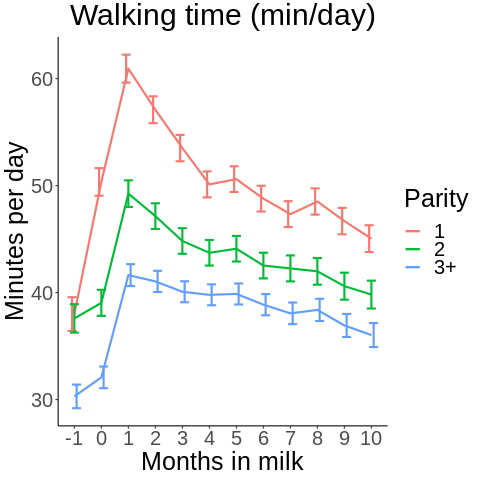

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/WalkingTimeParityByMonthsInMilk.png", width = 10, height = 8)

### MonthsInMilk by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|HerdIdentifier, type = "response", glhargs=list())

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.



In [ ]:
%%R
dfHerdIdentifier <- data.frame(HerdIdentifier = c("2011", "2297", "2514", "2746", "3", "3314", "544", "5888"),
                 Farm = c("CMS-P", "CMS-P", "AMS-C", "CMS-P", "CMS-P", "AMS-C", "AMS-C", "CMS-P")
                 )

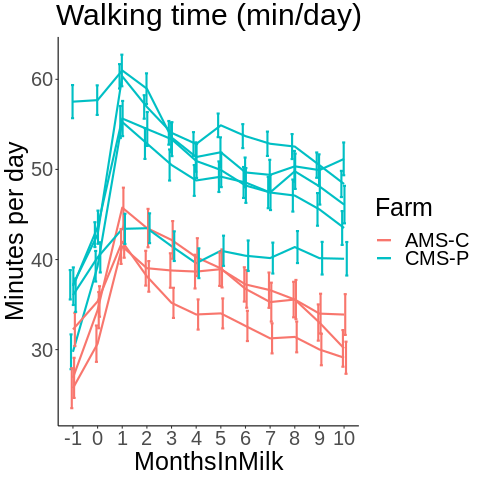

In [ ]:
%%R
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  dplyr::left_join(dfHerdIdentifier, by =  c("HerdIdentifier")) %>%
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(HerdIdentifier), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=HerdIdentifier, 
    color=Farm)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "MonthsInMilk") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/WalkingTimeMilkingTypeByMonthsInMilk.png", width = 10, height = 8)

### MonthsInMilk by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group    
 4              34.6 0.627 Inf      32.8      36.4  a        
 3              36.0 0.627 Inf      34.2      37.8  a        
 5              36.2 0.589 Inf      34.5      37.9  a        
 6              39.4 0.597 Inf      37.7      41.1   b       
 2              39.8 0.583 Inf      38.1      41.4   b       
 7              43.6 0.600 Inf      41.8      45.3    c      
 -1             45.1 0.707 Inf      43.1      47.1    cd     
 0              46.1 0.603 Inf      44.4      47.8     de    
 1              47.6 0.609 Inf      45.9      49.4      e    
 8              51.7 0.667 Inf      49.8      53.6       f   
 10             52.1 0.689 Inf      50.1      54.1       f   
 9              53.5 0.678 Inf      51.5      55.4       f   

CalvingSeason = Spring:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group    
 -1             25.3 0.722 Inf      23.2      27.4  a        
 10             29.1 

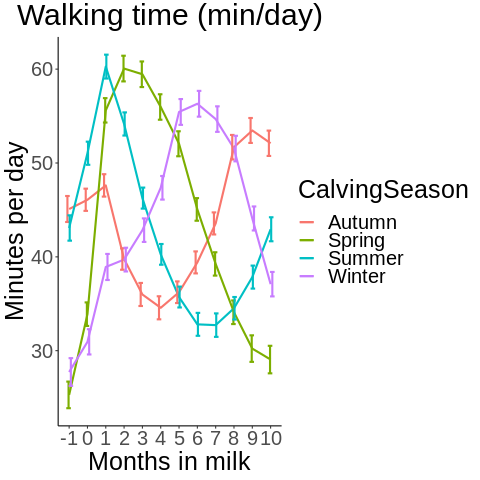

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line(size=1) +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=1,
    size=1,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(text=element_text(size=25),
        plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures122021/WalkingTimeCalvingSeasonByMonthsInMilk.png", width = 10, height = 8)

### MonthsInMilk by MilkingType by CalvingSeason

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54073' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54073' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54073)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS, CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group    
 4              27.0 2.12 Inf      20.9      33.1  a        
 3              27.7 2.20 Inf      21.4      34.0  abc      
 5              28.3 2.06 Inf      22.4      34.2  ab       
 2              30.5 2.30 Inf      24.0      37.1   bcd     
 6              31.2 2.03 Inf      25.3      37.0    c      
 7              35.0 2.04 Inf      29.2      40.9     de    
 -1             38.5 2.74 Inf      30.7      46.4      ef   
 0              39.0 2.56 Inf      31.7      46.3      ef   
 1              39.4 2.43 Inf      32.4      46.3      ef   
 8              42.6 2.09 Inf      36.7      48.6       f   
 10             42.7 2.24 Inf      36.3      49.1       f   
 9              44.2 2.15 Inf      38.1      50.4       f   

MilkingType = AMS, CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group    
 -1             18.9 2.75 Inf      11.1      26.8  ab      

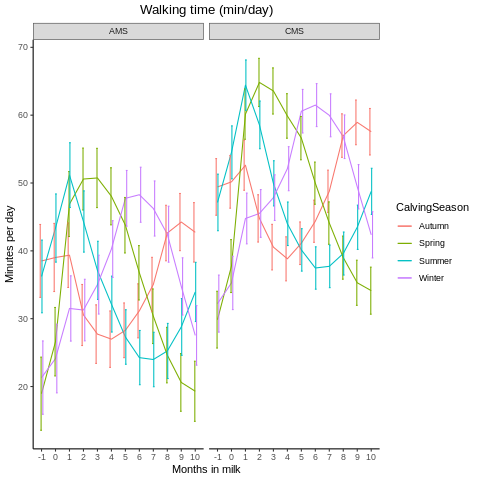

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType,CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  facet_wrap(~MilkingType) + 
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.5,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

# Model without 3 way interaction

In [ ]:
%%R
AnalysisDataAMS <- AnalysisData %>% dplyr::filter(MilkingType == "AMS")
AnalysisDataCMS <- AnalysisData %>% dplyr::filter(MilkingType != "AMS")

## MonthsInMilk by calving season AMS

In [ ]:
%%R
ModelAMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                     (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataAMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelAMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 16514' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 16514)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 16514' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 16514)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group 
 6              31.5 1.066 Inf      28.5      34.6  a     
 7              31.6 1.165 Inf      28.3      35.0  a     
 5              32.2 0.979 Inf      29.4      35.0  ab    
 4              33.1 0.944 Inf      30.4      35.8  abc   
 8              33.5 1.315 Inf      29.7      37.2  abcd  
 3              34.1 0.879 Inf      31.6      36.6  abc   
 -1             34.7 0.883 Inf      32.2      37.3  abcd  
 9              35.2 1.422 Inf      31.1      39.2   bcd  
 2              35.9 0.780 Inf      33.7      38.1    cd  
 10             36.0 1.534 Inf      31.6      40.4    cd  
 0              37.7 0.766 Inf      35.5      39.9     d  
 1              42.4 0.786 Inf      40.2      44.7      e 

CalvingSeason = Spring:
 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group 
 -1             22.5 0.938 Inf      19.8      25.2  a     
 0              27.9 0.858 Inf      25.5      30.4   b    
 10    

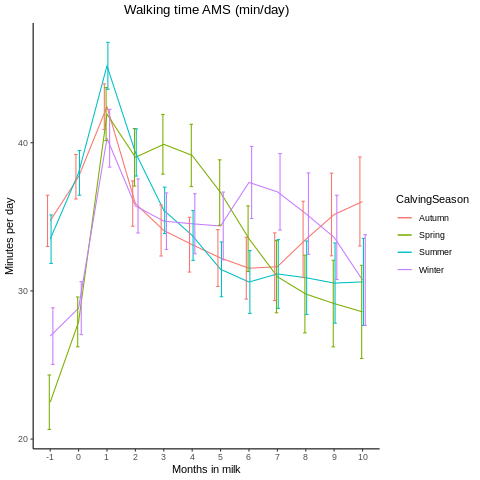

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.5,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time AMS (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures/WalkingTimeCalvingSeasonAMSByMonthsInMilk.png", width = 5, height = 4)

## MonthsInMilk by calving season CMS

In [ ]:
%%R
ModelCMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                     (1 + numMonthsInMilk| HerdIdentifier/AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataCMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelCMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 37559' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 37559)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 37559' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 37559)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 4              35.8 2.03 Inf      30.0      41.6  a       
 3              37.4 2.12 Inf      31.3      43.4  ab      
 5              39.1 1.95 Inf      33.5      44.7   bc     
 2              42.3 2.20 Inf      36.0      48.6    cd    
 6              43.9 1.90 Inf      38.5      49.4     d    
 7              50.3 1.87 Inf      45.0      55.7      e   
 0              50.5 2.45 Inf      43.5      57.5      e   
 1              51.2 2.33 Inf      44.6      57.9      e   
 -1             51.3 2.63 Inf      43.8      58.8      e   
 10             60.7 1.95 Inf      55.1      66.3       f  
 8              61.4 1.90 Inf      56.0      66.8       f  
 9              63.3 1.91 Inf      57.8      68.8       f  

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1             28.4 2.63 Inf      20.9      35.9  a       
 10             30.2 1.98 Inf      24.5      35.8  

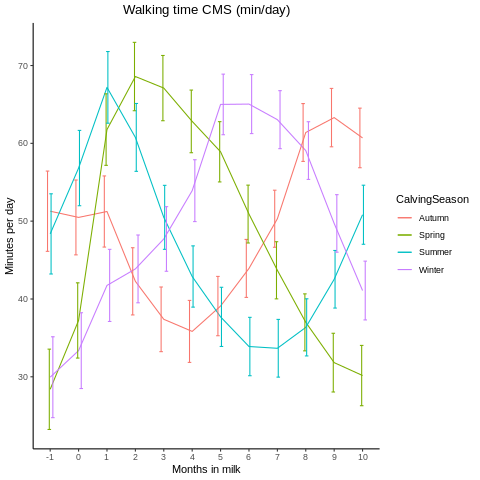

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.5,
    position=position_dodge(0.25)) +
  labs(
    title = "Walking time CMS (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ggsave("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/DiurnalPattern/Figures/WalkingTimeCalvingSeasonCMSByMonthsInMilk.png", width = 5, height = 4)